# Main training code

#### Uncomment this if you are running on google colab

In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.append('/content/drive/MyDrive/ml/model')

Mounted at /content/drive


In [25]:
from .base_model import CardClassifierModel
from .consts import (
    LEARNING_RATE,
    BATCH_SIZE,
    SHUFFLE,
    EPOCHS,
    DEVICE,
    CLASS_MAPPING_PATH,
    MODEL_PATH,
)
from .data_loader import CardDataset
import torch.nn as nn
import torch.optim as optim
import json
from torch.utils.data import DataLoader
import torch
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import os

### Check for CUDA support

In [26]:
print("Torch", torch.__version__, "CUDA", torch.version.cuda)
print("Device:", DEVICE)

CUDA Available: True
GPU: Tesla T4
accelerator: cu80
Torch 2.5.1+cu121 CUDA 12.1
Device: cuda:0


### Fetch the data

In [27]:
data_loader = CardDataset()

train_set = data_loader.train
test_set = data_loader.test
val_set = data_loader.val

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

Dataset downloaded to: /root/.cache/kagglehub/datasets/gpiosenka/cards-image-datasetclassification/versions/2


Class mappings

In [28]:
class_mapping = {v: k for k, v in train_set.class_to_idx.items()}
print(class_mapping)

# save to json
with open(CLASS_MAPPING_PATH, "w") as f:
    json.dump(class_mapping, f)

image, label = train_set[100]
image.shape

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

torch.Size([3, 128, 128])

### Load the model

In [29]:
DEVICE

device(type='cuda', index=0)

In [30]:
model = CardClassifierModel(num_classes=len(class_mapping))
model.to(DEVICE)

CardClassifier(
  (base): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Identity()
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Co

##### Loss: Cross-Entropy | Optimizer: Adam

In [31]:
print("Learning rate: ", LEARNING_RATE)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Learning rate:  0.001


In [32]:
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    model.train()
    train_loss_total = 0.0
    for train_images, train_labels in tqdm(train_loader, desc="Training"):
        # move data to device
        train_images, train_labels = train_images.to(DEVICE), train_labels.to(DEVICE)

        # clear gradient
        optimizer.zero_grad()

        # perform forward pass
        output = model(train_images)

        # calc loss
        loss = loss_function(output, train_labels)

        # perform backward pass
        loss.backward()

        # optimizer step
        optimizer.step()

        batch_loss = loss.item()
        train_loss_total += batch_loss * train_images.size(0)

    # epoch loss
    train_loss = train_loss_total / len(train_loader.dataset)
    train_losses.append(train_loss)

    # validation mode
    model.eval()
    val_loss_total = 0.0

    with torch.no_grad():
        for val_images, val_labels in tqdm(val_loader, desc="Validation"):
            # move data to device
            val_images, val_labels = val_images.to(DEVICE), val_labels.to(DEVICE)

            # forward pass
            output = model(val_images)

            # calc loss
            loss = loss_function(output, val_labels)
            batch_loss = loss.item()
            val_loss_total += batch_loss * val_images.size(0)

    val_loss = val_loss_total / len(val_loader.dataset)
    val_losses.append(val_loss)
    print(
        f"Epoch {epoch + 1}/{EPOCHS} - Train loss: {train_loss}, Validation loss: {val_loss}"
    )

Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/10 - Train loss: 1.5719552075124863, Validation loss: 0.5344617380286163


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/10 - Train loss: 0.588716953836483, Validation loss: 0.18255358928779386


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/10 - Train loss: 0.33424553902114174, Validation loss: 0.18981753975715276


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/10 - Train loss: 0.23613560479622947, Validation loss: 0.1859175108794896


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/10 - Train loss: 0.20561673940557124, Validation loss: 0.1836202154744346


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6/10 - Train loss: 0.16775678720125872, Validation loss: 0.17700766226593054


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7/10 - Train loss: 0.12934319331757294, Validation loss: 0.12390518930723082


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8/10 - Train loss: 0.1103663652654491, Validation loss: 0.18883949914630854


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9/10 - Train loss: 0.11017677683387135, Validation loss: 0.17641855444548266


Training:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10/10 - Train loss: 0.11370029535773919, Validation loss: 0.1206588532845929


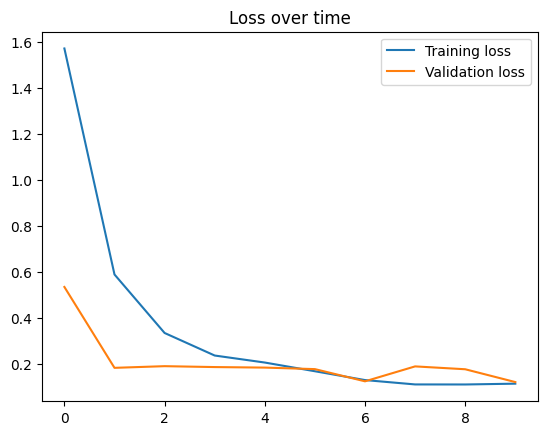

In [33]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Validation loss")
plt.legend()
plt.title("Loss over time")
plt.show()

### Save model weights

In [37]:
torch.save(model.state_dict(), MODEL_PATH)